# Leverage Visual AI for geospatial data

This accelerator shows how you can use Visual AI on geospatial data. Instead of deriving numeric features from the georeferenced data, you look at the geospatial data as images. For example, if you have a map of population distribution, instead of extracting the population that corresponds to each row of the main table you can pass the region of the map that corresponds to that row. This provides more information than a raw count of the population would, as it also encodes the distribution within the region (is it uniform or does it concentrate in some areas? what is the shape?, etc.)

The example used to illustrate the approach comes from work done with the [Virtue Foundation](https://virtuefoundation.org/2021/05/virtue-foundation-datarobot-ai-conference/). As part of the "Data Mapping Initiative", DataRobot has built models to identify suitable locations for new healthcare facilities. By looking at the location of existing hospitals and clinics as a function of several features (road networks, population, terrain, etc.) you find which other areas are suitable in terms of these features (similar to a propensity model).

This work has been peer reviewed and published at the [2023 IEEE International Conference on Imaging Systems and Techniques (IST)](https://ieeexplore.ieee.org/abstract/document/10355652).


The accelerator is organized as follows:

1. Dependencies
2. The data
3. Pre-processing
4. Training the model
5. Scoring

## Dependencies

As you will be working with geospatial data, you will need some additional librares that allow you to work with rasters and shapely files.

In [ ]:
!pip install geopandas
!pip install rasterio
!pip install contextily

In [10]:
import os
from pathlib import Path

import contextily as cx
import datarobot as dr

# packages for reading / manipulating geospatial data.
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio import mask, plot

In [11]:
from importlib import reload

import visualAImaps as vaim

In [12]:
reload(vaim)

<module 'visualAImaps' from '/Users/daniel.straulino/Documents/Accounts/VF/python/Accelerator/visualAImaps.py'>

## Data

This accelerator uses Mongolia as a case study here. Virtue Foundation has provided the data.

1. Outline of the country (from the geopandas library)
2. Healthcare facilities in Mongolia (with coordinates for each facility)
3. Georeferrenced "layers" for the country:
    * Population
    * Road network
    * Elevation (altitude)
    * Land cover
  
Besides the outline, all the data is found in an S3 bucket. Download the data and rename the folder to make sure that the path matches the code below.

After creating a local folder with the data, load it into a dictionary to better scale the code when you want to look at more than one country or region.

### Download the data

Optional step.

In [4]:
# If not already in the local folder, download the data to a local folder "original_data"

from io import BytesIO
import os
import zipfile

import requests

# Specify the folder name you want to check
folder_name = "original_data"
folder_path = os.path.join(os.getcwd(), folder_name)

# Check if the folder exists in the current directory
if os.path.exists(folder_path) and os.path.isdir(folder_path):
    print(f"The folder '{folder_name}' already exists in the current directory.")
else:
    print(
        f"The folder '{folder_name}' does not exist in the current directory. Downloading from S3"
    )
    # URL of the ZIP file
    zip_url = "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/geo_data.zip"
    # Download the ZIP file
    print("Downloading ZIP file...")
    response = requests.get(zip_url)
    zip_content = response.content
    # Use BytesIO to open the downloaded ZIP file in memory
    zip_file = BytesIO(zip_content)

    # Unzip the file and save its contents to the output folder
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall()
        print("Contents extracted")

    current_folder_name = "geo_data"
    new_folder_name = "original_data"
    # Optionally, list the contents of the output folder
    try:
        # Rename the folder
        os.rename(current_folder_name, new_folder_name)
        print(f"Folder renamed from '{current_folder_name}' to '{new_folder_name}'")
    except OSError as error:
        print(f"Error: {error}")

    for root, dirs, files in os.walk(current_folder_name):
        for file in files:
            print(os.path.join(root, file))

The folder 'original_data' already exists in the current directory.


## Load the data into a dictionary

In [5]:
reg_d = {}
# Name of region
reg_d["name"] = "Mongolia"
# Facilities should include geolocation
reg_d["facilities"] = "original_data/MongoliaFacilities.csv"
# All raster files
reg_d["rasters"] = {
    "POP": "original_data/MNG_population_reprojected.tif",
    "ROAD": "original_data/MNG_roads.tif",
    "ELEV": "original_data/MNG_srtmfixed.tif",
    "COVER": "original_data/MNG_esrifixed.tif",
}
# You need to ensure that you are consistent in the projections you use, therefore take the crs below to be the default
reg_d["crs"] = rio.open("original_data/MNG_population_reprojected.tif", "r+").crs

While it would be possible to start building the training data and start the modelling process right away, it will be useful to first understand the data better. Begin by plotting the locations all existing healthcare facilities in Mongolia.

In [6]:
# Load the facilities data and the country profile
facilities = pd.read_csv(reg_d["facilities"])
region_outline = vaim.get_country_outline(reg_d["name"], reg_d["crs"], 0)
# Pass them (together with the crs) to this function to create a geopandas dataframe
facilities_gdf = vaim.facilities_to_gpd(facilities, reg_d["crs"], region_outline)

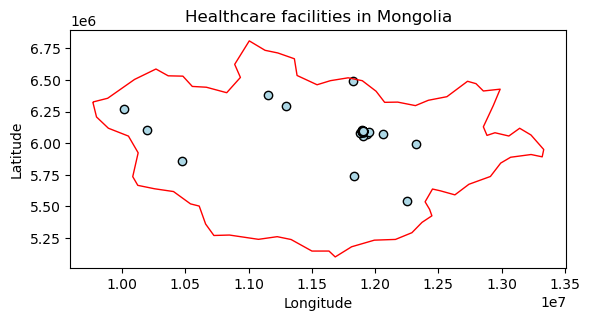

In [7]:
# Change the projection to use a background map
gdf_temp = facilities_gdf.to_crs(epsg=3857)
polygon_temp = gpd.GeoSeries([region_outline], crs=reg_d["crs"]).to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1)
gdf_temp.plot(ax=ax, color="lightblue", edgecolor="black")
polygon_temp.plot(ax=ax, color="none", edgecolor="red")

# Set titles, labels, etc.
ax.set_title("Healthcare facilities in Mongolia")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# ax.set_xlim([gdf_temp.total_bounds[0], gdf_temp.total_bounds[2]])
# ax.set_ylim([gdf_temp.total_bounds[1], gdf_temp.total_bounds[3]])

plt.show()

Above you can see the current locations. You want to build a model that will suggest good candidates for new locations based on some geospatial data concerning population distribution, land coverage, elevation and road network. Take a quick look at what this data looks like.

In [8]:
rstr_landcover = rio.open(reg_d["rasters"]["COVER"], "r+")
rstr_elev = rio.open(reg_d["rasters"]["ELEV"], "r+")
rstr_pop = rio.open(reg_d["rasters"]["POP"], "r+")
rstr_roads = rio.open(reg_d["rasters"]["ROAD"], "r+")

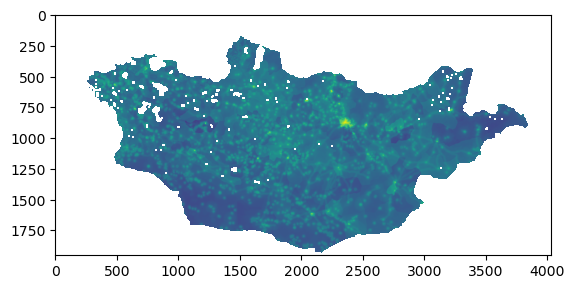

In [13]:
vaim.plot_raster(rstr_pop)

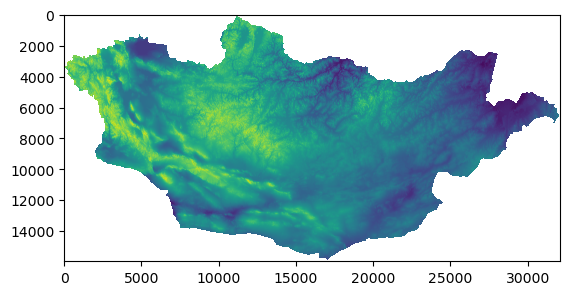

In [14]:
vaim.plot_raster(rstr_elev)

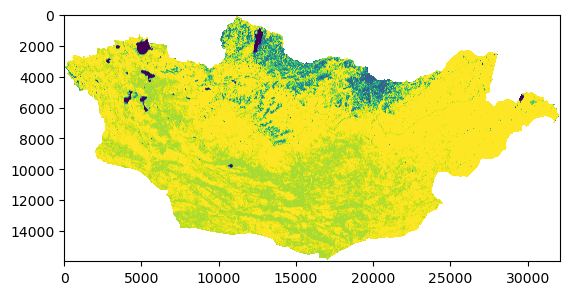

In [15]:
vaim.plot_raster(rstr_landcover)

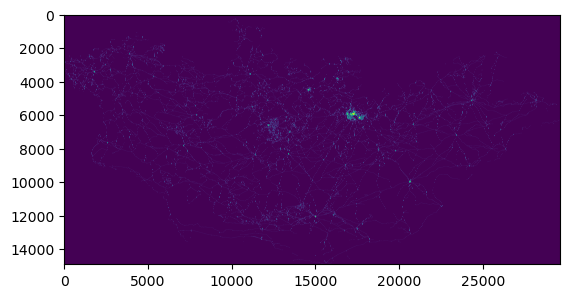

<AxesSubplot:>

In [29]:
rio.plot.show(rstr_roads.read(masked=True))

## Pre-processing

The previous section outlines the types of data utilized in this project, including geographical information (like population and roads) and the current locations of healthcare facilities. Our objective is to identify potential sites for new facilities based on these variables.

Employ a spatial look-alike model strategy. This involves analyzing the traits of regions with existing facilities to find other areas with similar characteristics, indicating their suitability for new healthcare infrastructure.

The approach consists of the following steps:

1. Build a training dataset.

   * For every facility in the dataset, draw a square of side "chip_length" (say 5km) around it. This will be the "positive class" in the training data. 
   
   * Sample random locations in the region (Mongolia). If they are further away than "exclusion_zone" add them to the list, if not sample a new one. This will be the "negative class". Continue sampling until you meet the threshold set by the "proportion_random_points" parameter which tells you how many negatives you will create per each positive.

   * Add four images to each row, one for each variable (population, roads, elevation, land cover). These images will be the result of cropping the full raster according to the geometry of the row.
   
2. Use DataRobot to train a model using the dataset shared previously.

3. Split the whole region (Mongolia) into small cells using a grid.

4. Score the cells that were not part of the training data. Those that score highly will be more "suitable" than those with low scores.
 
In this section you will illustrate how to build the training data.

In [17]:
# Determine the modeling options
reg_d["modelling"] = {
    "chip_length": 5,
    "exclusion_zone": 1,
    "proportion_random_points": 30,
}

Add the modeling parameters to the main dictionary:

* chip_length: The size of the cells you will divide the region into.
* exclusion_zone: How far from the existing facilities you are going to sample the "negative class" for training.
* proportion_random_points: How many locations you will add as "negative_class" examples per each existing healthcare facility.

The training data creation function only takes one argument, a dictionary that specifies both the modeling parameters and the paths to the data. Once it is fully specified, you just need to run one line:

In [18]:
# Create training data

zip_file, zip_path = vaim.create_training_data(reg_d)

In [19]:
training_data = pd.read_csv("TEMP/Mongolia/train.csv")
training_data.head()

,target,POP,ROAD,ELEV,COVER
0,True,/images/POP0.png,/images/ROAD0.png,/images/ELEV0.png,/images/COVER0.png
1,True,/images/POP1.png,/images/ROAD1.png,/images/ELEV1.png,/images/COVER1.png
2,True,/images/POP2.png,/images/ROAD2.png,/images/ELEV2.png,/images/COVER2.png
3,True,/images/POP3.png,/images/ROAD3.png,/images/ELEV3.png,/images/COVER3.png
4,True,/images/POP4.png,/images/ROAD4.png,/images/ELEV4.png,/images/COVER4.png


In [20]:
from IPython.display import display, HTML, Image

image_paths = [
    "TEMP/Mongolia/images/COVER11.png",
    "TEMP/Mongolia/images/ELEV0.png",
    "TEMP/Mongolia/images/POP0.png",
    "TEMP/Mongolia/images/ROAD11.png",
]  # Add your image paths here

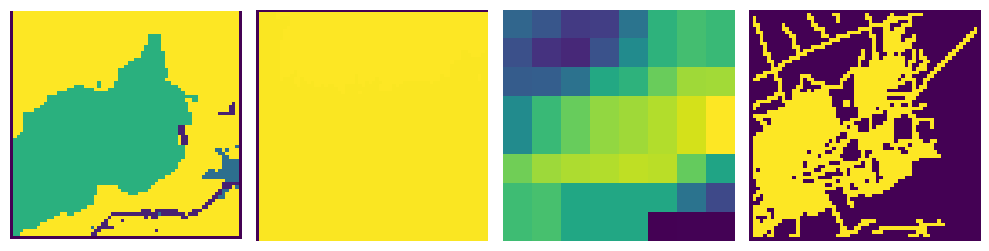

In [30]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
axes = axes.flatten()  # Flatten in case of a single row

# Loop through the images and display each one
for ax, image_path in zip(axes, image_paths):
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.axis("off")  # Hide axes

# Hide unused subplots if the number of images is not a perfect fit for the grid
for ax in axes[len(image_paths) :]:
    ax.axis("off")

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

Above we can see an example of what the data looks like. You might notice that the resolution is not the same for all sourcers, but that won't be a problem, what matters is that they all correspond to the same cell in the grid.

## Train the model

You are now ready to train a model in DataRobot. To do so you need your credentials.

In [26]:
# Train the model and register project ID and deployment ID
# You need your DataRobot credentials, token, and endpoint
# This example uses a yaml but you can add both strings
credentials_yaml = vaim.read_yaml_file("/Users/daniel.straulino/Documents/drconfig_us.yaml")
credentials = [credentials_yaml["token"], credentials_yaml["endpoint"]]

In [ ]:
project_name = "VisualAI example"
pid, did = vaim.train_and_deploy_suitability_model(project_name, zip_path, credentials)

In [ ]:
project = dr.Project.get(pid)
top_model = project.get_top_model()
top_model

## Scoring

You have deployed the DataRobot model and are now able to get send prediction requests. You would like to get a score for each cell in the grid you have done.

The function `create_scoring_data` follows the same steps you used for creating the training data:

* Divide the whole region (Mongolia in this case) into cells using a grid.
* Gor each cell, crop the rasters/images to the corresponding square.
* Dave the cropped images and add the paths to the scoring dataset.

Use the `get_encoded_image_contents_from_paths` function from the from DataRobot `helpers.binary_data_utils` library to then convert the images into binary representations that will be faster to score with the model.

In [22]:
# Create the scoring data

scoring_csv_path, images_path = vaim.create_scoring_data(reg_d)
scoring_data = pd.read_csv(scoring_csv_path + "/scoring.csv")

In [23]:
from datarobot.helpers.binary_data_utils import get_encoded_image_contents_from_paths

for col in reg_d["rasters"]:
    scoring_data[col] = get_encoded_image_contents_from_paths(scoring_data[col])

In [24]:
scoring_data.to_csv("scoring_data.csv", index=False)

In [27]:
did = "65ab19d2e68555cc98baed56"
predictions = vaim.predictions_scoring_data(credentials, did, "scoring_data.csv")

<AxesSubplot:>

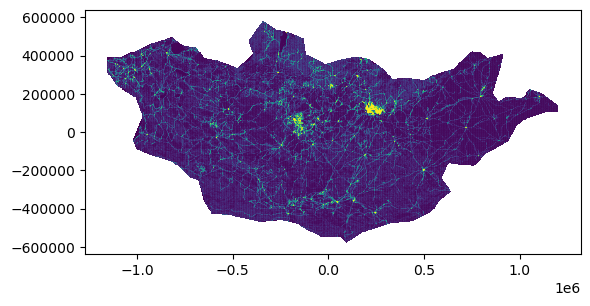

In [28]:
predictions.plot("prediction")

In [ ]:
predictions.head()